### Phys 629, Fall 2023, University of Mississippi


# Lecture 19, Chapter 5: Bayesian Statistical Inference

Material in this lecture and notebook is based upon the Basic Stats portion of G. Richards' "Astrostatistics" class at Drexel University (PHYS 440/540, https://github.com/gtrichards/PHYS_440_540), the Introduction to Probability & Statistics portion of A. Connolly's & Ž. Ivezić's "Astrostatistics & Machine Learning" class at the University of Washington (ASTR 598, https://github.com/dirac-institute/uw-astr598-w18), J. Bovy's mini-course on "Statistics & Inference in Astrophysics" at the University of Toronto (http://astro.utoronto.ca/~bovy/teaching.html), and Stephen R. Taylor (https://github.com/VanderbiltAstronomy/astr_8070_s22). 

##### Reading:

- [Textbook](http://press.princeton.edu/titles/10159.html) Chapter 5.
- [MCMC Sampling](https://twiecki.io/blog/2015/11/10/mcmc-sampling) by Thomas Wiecki.
- [Sampler, Samplers, Everywhere...](http://mattpitkin.github.io/samplers-demo/pages/samplers-samplers-everywhere/) by Matt Pitkin.
- [MCMC Interactive Demo](https://chi-feng.github.io/mcmc-demo/app.html) by Chi Feng.

***Exercises required for class participation are in <font color='red'>red</font>.***

Please pause for a few minutes and install these two packages `emcee`, `pymc3`, and `PTMCMCSampler` before going through today's notebook. Make sure this notebook is in the correct Python kernel for the class conda environment before executing each of the following cells in turn.

In [7]:
# !pip3 install emcee

In [8]:
# !pip3 install pymc3

In [9]:
# !pip3 install git+https://github.com/dfm/acor@master

In [10]:
# !pip3 install git+https://github.com/jellis18/PTMCMCSampler@master

## Monte Carlo Methods & Markov Chains <a class="anchor" id="one"></a>

### Motivation

Consider the problem of estimating location and scale parameters for homoscedastic data drawn from a Gaussian distribution that we looked at earlier. We had a two-dimensional posterior pdf for $\mu$ and $\sigma$:

![Ivezic, Figure 5.5](http://www.astroml.org/_images/fig_likelihood_gaussian_1.png)

It was easy to *numerically* integrate the posterior pdf to find the marginal distributions, and find its maximum, using a brute-force grid search because it was only a $2$D problem. With $100$ grid points per coordinate it was only $10^4$ values. 

However, **what about high parameter dimensions?**
- Even in a case of rather simple $5$D problem (as we'll discuss later today), we'd have $10^{10}$ values! And often we work with models of much higher dimensionality (it can be thousands!). **Brute-force grid methods are not feasible beyond a few dimensions**, and even then can be waste of time. 
- You could **simply randomly sample the grid at every point**, and try to find the minimum based on that. But that can also be quite time consuming, and you will spend a lot of time in regions of parameter space that yields small likelihood.

A better way is to adopt a ***Markov-Chain Monte Carlo (MCMC)***. MCMC gives us a way to make this problem computationally tractable by sampling the full multi-dimensional parameter space, in a way that builds up the most sample density in regions that are closest to the maximum probability. Then, you can post-process the “chain” of points to infer the posterior distribution and uncertainty regions.

Ivezic, Figure 5.22 shows a problem similar to the one above, done with a Markov Chain Monte Carlo algorithm.  The dashed lines are the known (analytic) solution.  The solid lines are from the MCMC estimate with 10,000 sample points.

![Ivezic, Figure 5.10](http://www.astroml.org/_images/fig_cauchy_mcmc_1.png)

### What does Monte Carlo mean?

In case you are not familiar with Monte Carlo methods, it derives from the name of an administrative area of the Principality of Monaco ([Monte Carlo](https://www.wikiwand.com/en/Monte_Carlo)) known for high-stakes casinos and gambling. Gambling and random sampling go hand in hand together.

![](https://www.thomascook.com/.imaging/mte/thomascook-theme/og-image/dam/legacy/heros/citybreaks/monte-carlo/montecarlohero.jpg/jcr:content/montecarlohero.jpg)

**EXAMPLE:** 
- You have forgotten the value of $\pi$, but you know the formula for the area of a square and how to draw a circle. 
- We can use the information that we *do* know to numerically compute $\pi$.

1. We start by drawing a square and circumscribing a circle in it (actually it suffices to just do a quarter of a circle and scale accordingly).
2. We put down random points within the square and note which ones land in the circle.
3. The ratio of random points in the circle to the number of random points drawn is related to the area of our circle, allowing us to calculate $\pi$.
4. Using more random points yields more precise estimates of the area.

<font color='red'>Try it below. How many draws does it take to get the error down to 1 part in a thousand?</font>

We'll consider one quadrant of a square of sides [-1,1] in which we inscribe a circle (actually just one quarter of a circle).

In [5]:
# Execute this cell
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

Text(0, 0.5, 'y')

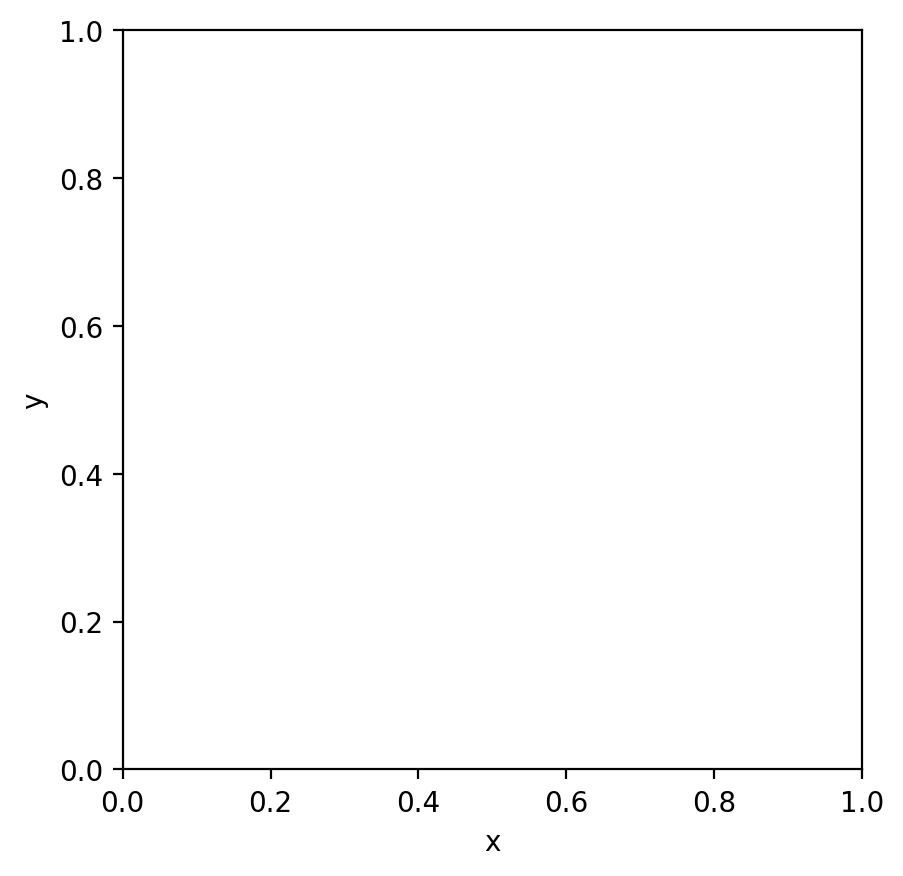

In [6]:
fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))
ax.axis([0, 1, 0, 1]);
plt.xlabel('x')
plt.ylabel('y')

Estimate of pi is 3.14235 for 1000000 draws with fractional error 0.00024.


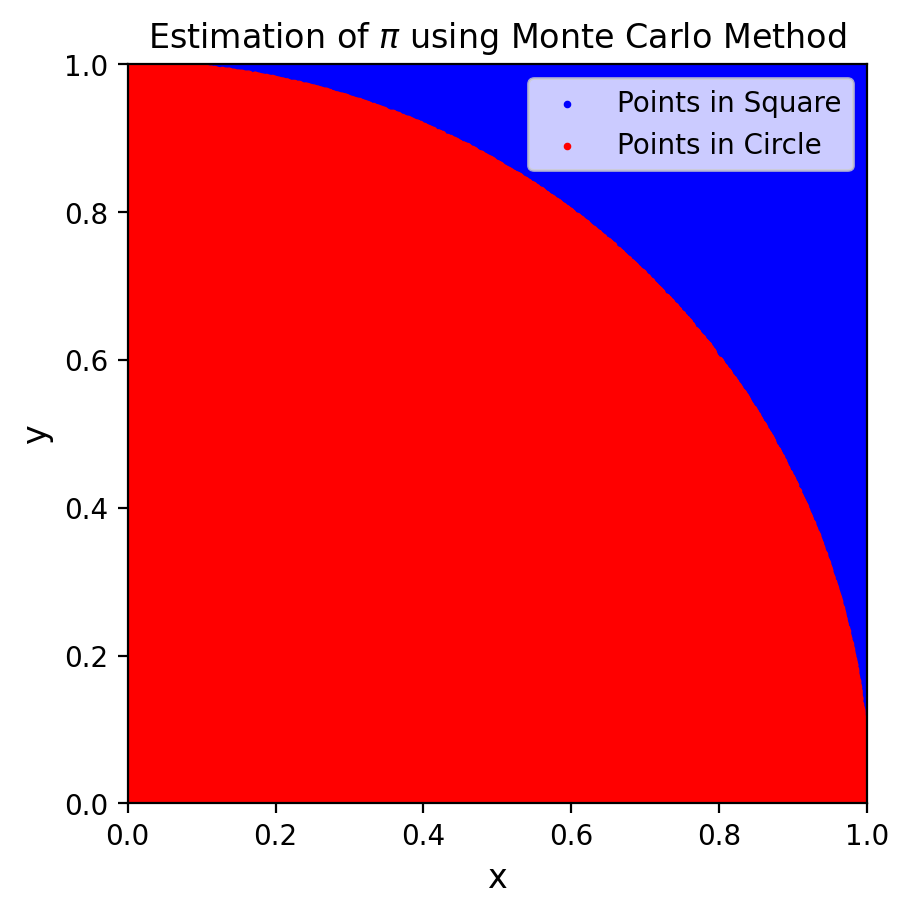

In [19]:


# Lay down M random points. Tally how many are within a unit circle.
M = 1000**2
x = stats.uniform(0, 1).rvs(M)  # M random draws between 0 and 1
y = stats.uniform(0, 1).rvs(M)  # M random draws between 0 and 1

r2 = x**2 + y**2  # equation for radius of circle in x, y

fig, ax = plt.subplots(subplot_kw=dict(aspect='equal'))

# Plot points in square
plt.scatter(x, y, color='blue', s=3, label='Points in Square')

# Plot points also in circle
plt.scatter(x[r2 < 1], y[r2 < 1], color='red', s=3, label='Points in Circle')

plt.xlabel('x', fontsize = '12')
plt.ylabel('y', fontsize = '12')
plt.legend(loc='upper right')
plt.title(r'Estimation of $\pi$ using Monte Carlo Method')

# Set axis limits to match the unit square
plt.xlim(0, 1)
plt.ylim(0, 1)

# A_square = d^2, Acircle = pi*d^2
piEst = 4 * np.sum(r2 < 1) / M  # pi = 4A/d^2, where A is d^2 times the ratio of points "in" to total points

print("Estimate of pi is {0:.5f} for {1} draws with fractional error {2:.5f}.".format(piEst, M, np.abs((np.pi-piEst)/np.pi)))

plt.show()


See also [this Khan Academy simulation](https://www.khanacademy.org/computer-programming/monte-carlo-finding-the-value-of-pi/6530004791197696/embedded?embed=yes&article=yes&editor=no&buttons=no&author=no&autoStart=yes&width=610&height=420).

- In general, ***Monte Carlo methods*** use random sampling to obtain a numerical result (e.g., the value of an integral), where there is no analytic result or it is difficult to obtain.
- In the case of the circle above, we have computed the intergral: $\int\int_{x^2+y^2\le 1} dx dy.$

Recall ***Monte Carlo integration***. 
- Our goal was to integrate $\int g(x)f(x)dx$. 
- We could do this on a grid of $x$, such that $\int g(x)f(x)dx \approx \sum_{i=1}^N g(x_i)f(x_i)\Delta x$, where we use the probability distribution at each grid point $f(x_i)$ as weights for the sum over $g(x_i)$.
- But we might waste terms in the sum over low probability areas. If we have random draws from $f(x)$ then the *density* of those points in $x$ directly represent the weighting we desire. We will get most weight in regions of high probability. 
- We can think of our random samples as $f(x)$ being a sum of $\delta$ functions at the sampled points, all overlapping to give high density at the high probability regions. The integral is then 

$$ \int g(x)f(x)dx \approx  \frac{1}{N}\sum_i^N g(x_i).$$

### What is a Markov Chain?

A Markov Chain is defined as 

> a sequence of random variables where a parameter depends *only* on the preceding value. Such processes are "memoryless".  
 
Mathematically, we have

$$p(\theta_{i+1}|\theta_i, \theta_{i-1}, \theta_{i-2}, \cdots) = p(\theta_{i+1}|\theta_i).$$

For  equilibrium, or a stationary distribution of positions, it is necessary that the transition probability is symmetric:

$$    p(\theta_{i+1}|\,\theta_i) = p(\theta_i |\, \theta_{i+1}). $$

This is called the ***principle of detailed balance*** or reversibility condition (i.e. the probability of a jump between two points does not depend on the direction of the jump).

**EXAMPLE** 

If you are an (*electromagnetic*) astronomer and you want to know how likely it is that tomorrow night will be clear given the weather tonight (clear or cloudy).  From past history, you know that:

$$p({\rm clear \; tomorrow} \, |\,  {\rm cloudy \; today}) = 0.5,$$

which means that

$$p({\rm cloudy \; tomorrow} \, |\, {\rm cloudy \; today}) = 0.5.$$

We also have

$$p({\rm cloudy \; tomorrow} \, |\, {\rm clear \; today}) = 0.1,$$

which means that

$$p({\rm clear \; tomorrow} \, |\, {\rm clear \; today}) = 0.9.$$

***NOTE:*** These numbers could be somewhat related to the mercurial weather we have in Oxford.

- We can start with the sky conditions today and make predictions going forward more and more into the future.
- This will look like a big decision tree. 
- After enough days, we'll reach equilibrium probabilities that have to do with the mean weather statistics (ignoring seasons) and we'll arrive at

$$p({\rm clear}) = 0.83,$$

and 

$$p({\rm cloudy}) = 0.17.$$

You get the same answer for day $N$ as day $N+1$ and it doesn't matter whether it was clear or cloudy on the day that you started. The steps that we have taken in this process are a **MARKOV CHAIN**.

Here is an illustration of this process from an article in [towarddatascience.com](https://towardsdatascience.com/introduction-to-markov-chains-50da3645a50d).

Sampling for $10,000$ days using this prescription gives a chain that looks like this:

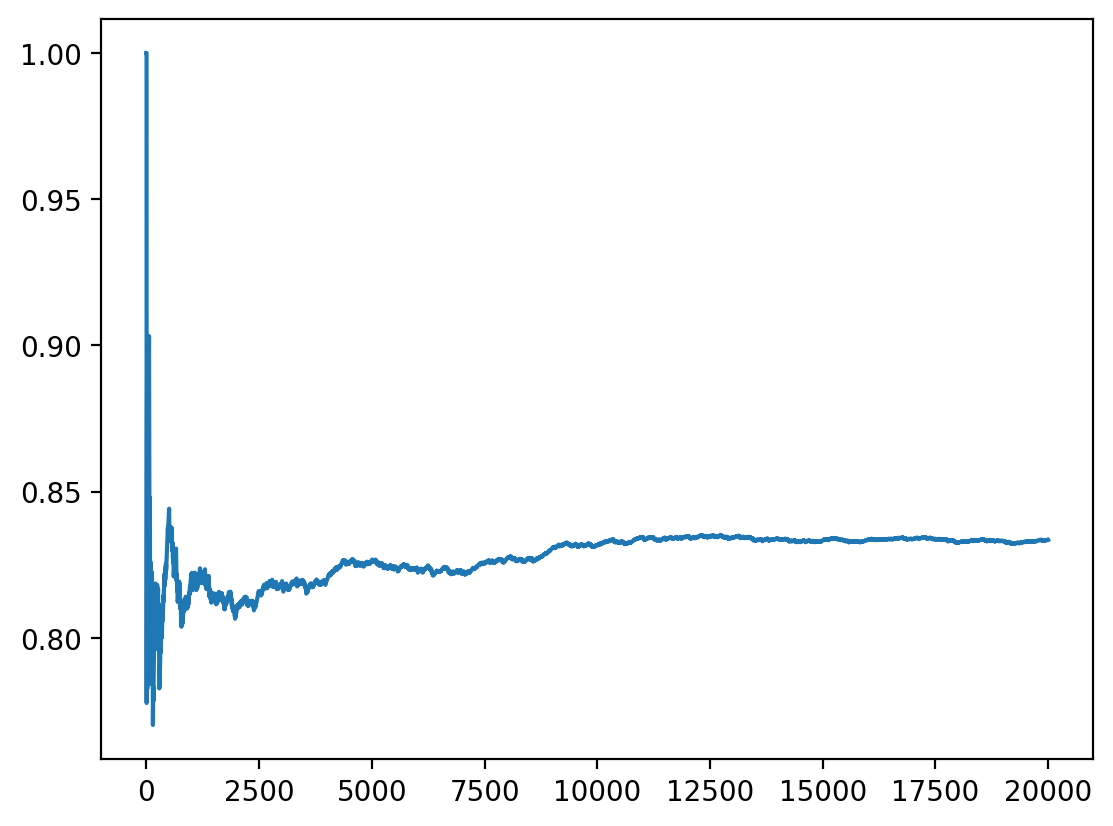

In [20]:
# Let's start off on a cloudy day
# Cloud = 0
# Clear = 1
weather = [0]

for ii in range(1,20000):
    # implementing forecasts based on above probabilities
    if weather[ii-1] == 1:
        weather.append(np.random.choice(np.array([0, 1]),
                                        p=np.array([0.1, 0.9])))
    elif weather[ii-1] == 0:
        weather.append(np.random.choice(np.array([0, 1]),
                                        p=np.array([0.5, 0.5])))
weather = np.array(weather)

running_clear = np.cumsum(weather)[1:]/np.arange(weather.shape[0])[1:]
# plot the running average
plt.plot(running_clear)
plt.show()

- The above figure is called a **trace-plot**, showing how our estimate of $p(\mathrm{clear})$ evolves as the chain samples. 
- A histogram of the above plot reveals the distribution of $p(\mathrm{clear})$. <font color='red'>We can use this to determine the most likely value and an error on our estimate.</font>

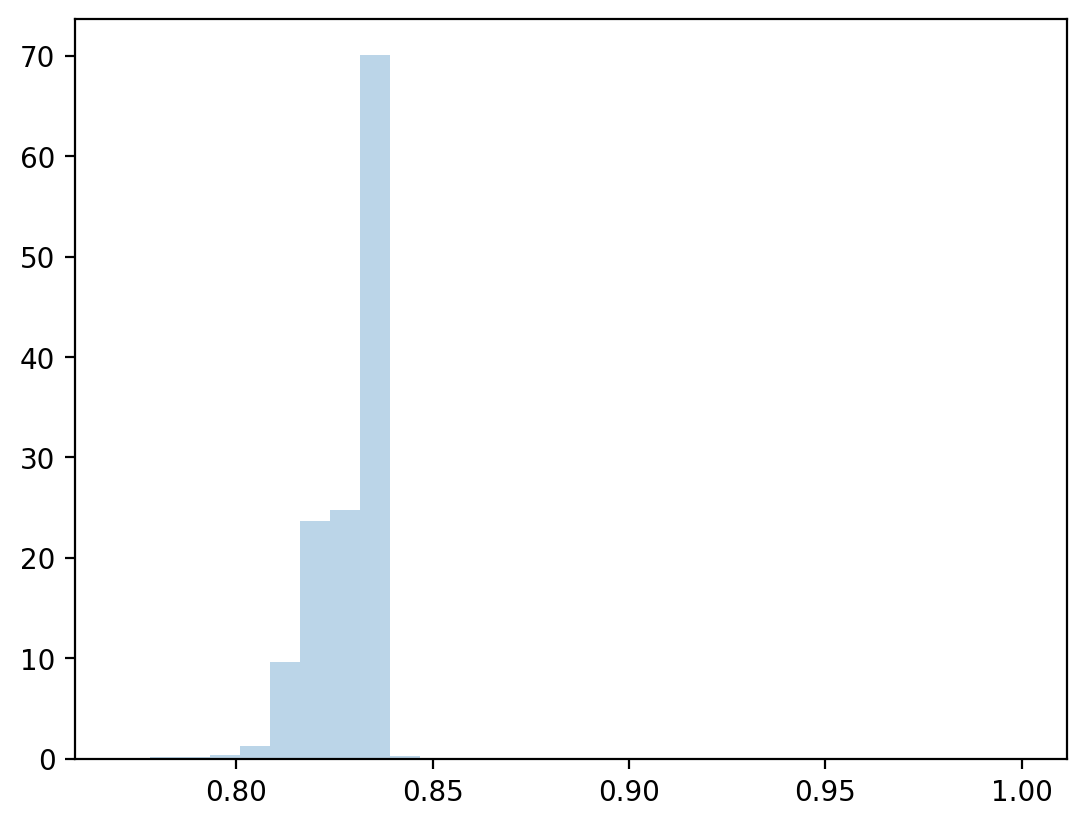

In [21]:
plt.hist(running_clear, bins=30, density=True, alpha=0.3);

- In MCMC the process must be **stationary** which basically means that the chain statistics look the same no matter which chunk you look at, e.g. first half, second half, or every other point, etc.  
- Obviously that isn't going to be the case in the early steps of the chain. In our example above, after some time the process was stationary, but not in the first few days.
- So, there is a **burn-in** phase that needs to be discarded. How one determines the number of early steps to discard as burn-in is tricky, but ***you should always start with a traceplot of your samples!!!***

<font color='red'>Try the above example again but this time start with a clear day. Also experiment with chopping off different numbers of initial points as burn-in from `running_clear`.</font>

Final Running Average: 0.8337283372833728


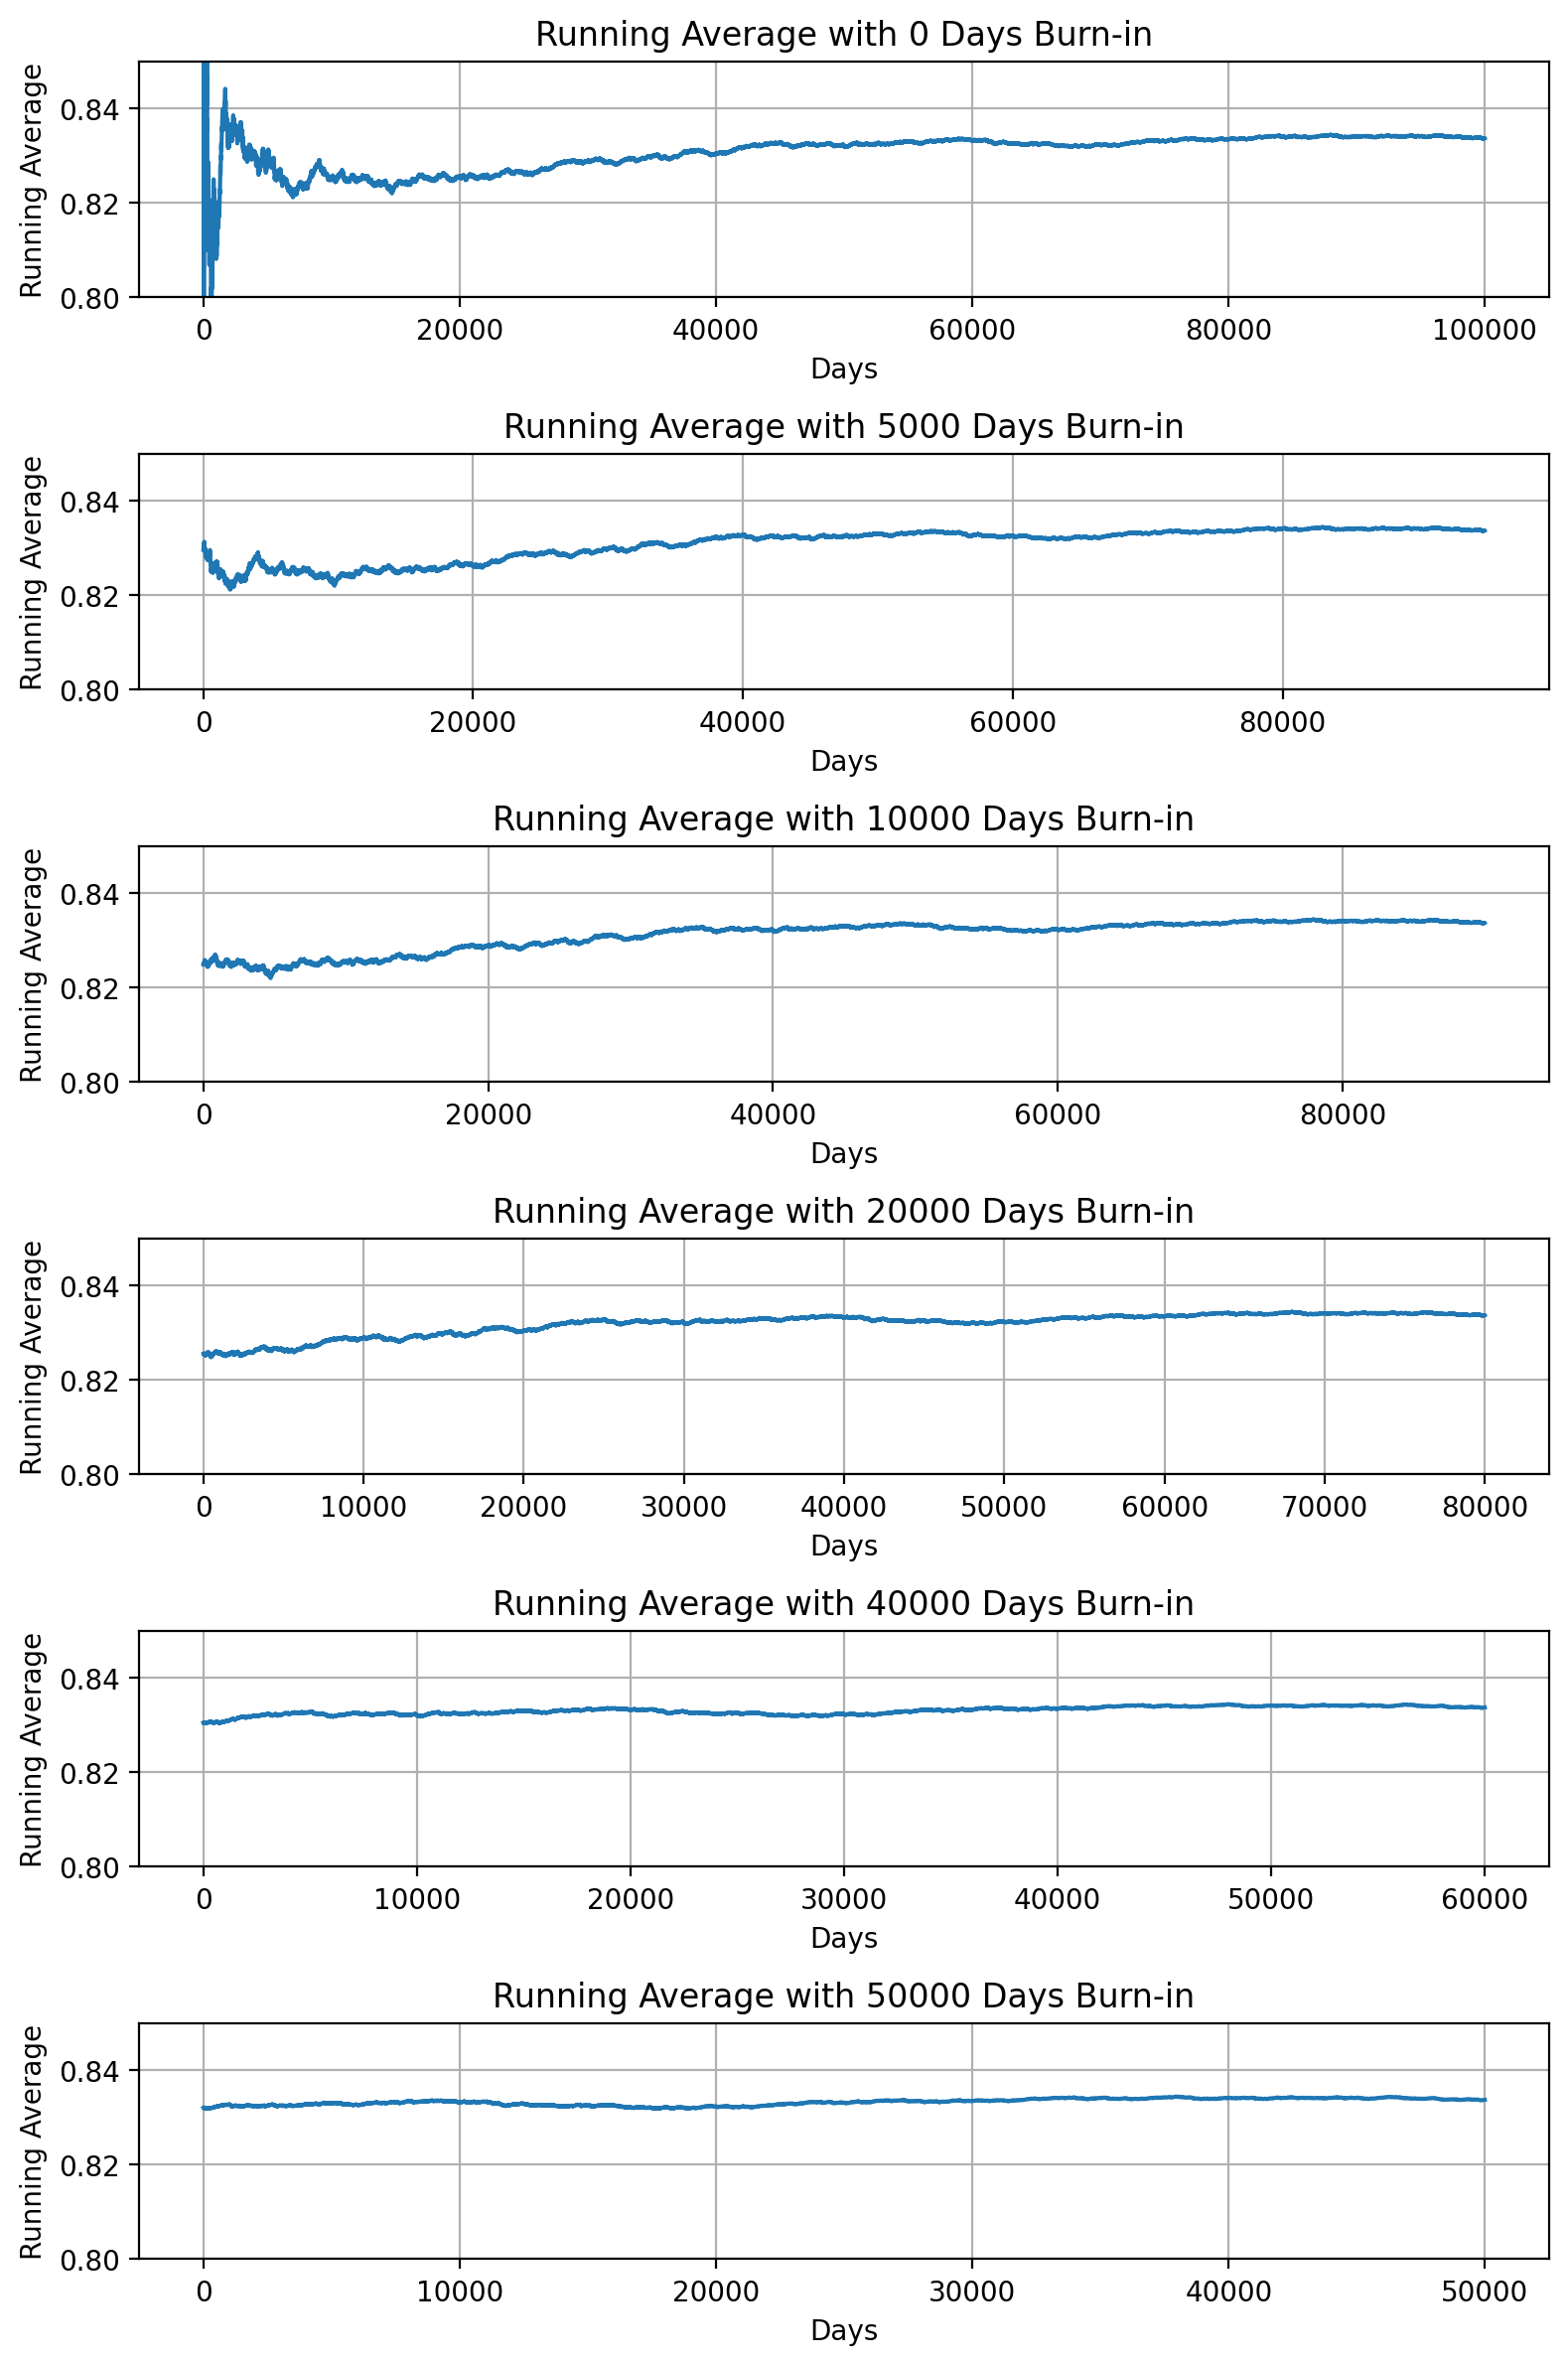

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Let's start off on a clear day
# Cloud = 0
# Clear = 1
weather_sim = [1]  # Start with a clear day

np.random.seed(223)

for day in range(1, 100000):
    # Implementing forecasts based on probabilities
    if weather_sim[day-1] == 1:
        weather_sim.append(np.random.choice([0, 1], p=[0.1, 0.9]))
    elif weather_sim[day-1] == 0:
        weather_sim.append(np.random.choice([0, 1], p=[0.5, 0.5]))

weather_sim = np.array(weather_sim)

running_clear_sim = np.cumsum(weather_sim)[1:] / np.arange(weather_sim.shape[0])[1:]

# Print the final running average
print("Final Running Average:", running_clear_sim[-1])

# Create subplots for different burn-in values
fig, axes = plt.subplots(6, figsize=(8, 12))
burn_ins = [0, 5000, 10000, 20000, 40000, 50000]

for i, burn_in in enumerate(burn_ins):
    axes[i].set_ylim(0.8, 0.85)
    axes[i].plot(running_clear_sim[burn_in:])
    axes[i].set_xlabel('Days')
    axes[i].set_ylabel('Running Average')
    axes[i].grid(True)
    axes[i].set_title(f'Running Average with {burn_in} Days Burn-in')

plt.tight_layout()
plt.show()
